In [1]:
from tvb.simulator.models.oscillator import Generic2dOscillator
from tvb.simulator.integrators import HeunStochastic
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
import pymc3 as pm
import scipy
import theano.tensor as tt
import theano
import math
from tqdm import tqdm

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Parameters
a_sim = 2.0
b_sim = -10.0
c_sim = 0.0
d_sim = 0.02
I_sim = 0.0

In [3]:
X = np.load("limit-cycle_simulation.npy")

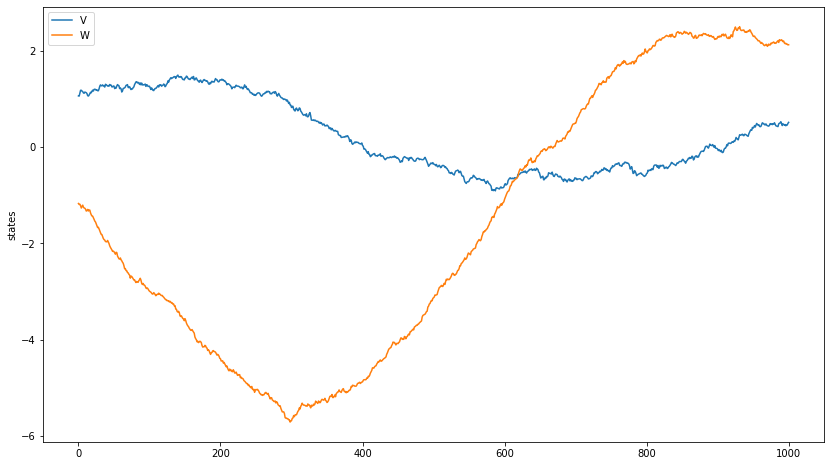

In [4]:
f1 = plt.figure(figsize=(14,8))
plt.plot(X[:, 0, 0, 0], label="V")
plt.plot(X[:, 1, 0, 0], label="W")
plt.ylabel("states")
plt.legend()
plt.show()

In [7]:
# global inference parameters
shape = X.shape
draws = 1000
tune = 1000

### Inference using non-centered model

In [8]:
from tvb.contrib.inversion.pymcInference import NonCenteredModel

In [9]:
ncModel = NonCenteredModel(Generic2dOscillator)

In [10]:
with ncModel.pymc_model:
    a_star = pm.Normal("a_star", mu=0.0, sd=1.0)
    a = pm.Deterministic("a", 2.0 + 0.1 * a_star)
    
    b_star = pm.Normal("b_star", mu=0.0, sd=1.0)
    b = pm.Deterministic("b", -10.0 + 0.1 * b_star)
    
    c_star = pm.Normal("c_star", mu=0.0, sd=1.0)
    c = pm.Deterministic("c", 0.0 + 0.1 * c_star)
    
    d_star = pm.Normal("d_star", mu=0.0, sd=1.0)
    d = pm.Deterministic("d", 0.02 + 0.001 * d_star)
    
    I_star = pm.Normal("I_star", mu=0.0, sd=1.0)
    I = pm.Deterministic("I", 0.0 + 0.1 * I_star)
    
    # Passing the prior distributions as dictionary. Also including fixed model parameters.
    priors = {
        "a": a,
        "b": b,
        "c": c,
        "d": d,
        "I": I,
        "tau": np.array([1.0]),
        "e": np.array([3.0]),
        "f": np.array([1.0]),
        "g": np.array([0.0]),
        "alpha": np.array([1.0]),
        "beta": np.array([1.0]),
        "gamma": np.array([1.0])
    }
    
    consts = {"coupling": np.zeros([2, 1, 1]), 
              "local_coupling": 0.0}
    
    obs = {"x_obs": X}
    
    time_step = 0.1
    
    x_init_star = pm.Normal("x_init_star", mu=0.0, sd=1.0, shape=shape[1:])
    x_init = pm.Deterministic("x_init", 0.0 + x_init_star)
    
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    noise = BoundedNormal("noise", mu=0.0, sd=1.0)
    
    amplitude_star = pm.Normal("amplitude_star", mu=0.0, sd=1.0)
    amplitude = pm.Deterministic("amplitude", 1.0 + amplitude_star)
    
    offset_star = pm.Normal("offset_star", mu=0.0, sd=1.0)
    offset = pm.Deterministic("offset", 0.0 + offset_star)
    
    epsilon = BoundedNormal("epsilon", mu=0.0, sd=1.0)

In [11]:
ncModel.set_model(priors, consts, obs, time_step, x_init, noise, amplitude, offset, epsilon, shape)

In [ ]:
nc_data = ncModel.run_inference(draws=draws, tune=tune, cores=1, target_accept=0.9)

/Users/erichter/opt/anaconda3/envs/BrainSim-env/lib/python3.7/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


In [ ]:
ncModel.plot_posterior(init_params={"a": a_sim, "b": b_sim, "c": c_sim, "d": d_sim, "I": I_sim})

In [ ]:
posterior_x_obs = nc_data.posterior_predictive.x_obs.values.reshape((draws + tune, *shape))

In [ ]:
f3 = plt.figure(figsize=(14,8))
plt.plot(t, np.percentile(posterior_x_obs[:, :, 0, 0, 0], [2.5, 97.5], axis=0).T, 
         "k", label=r"$V_{95\% PP}(t)$")
plt.plot(t, np.percentile(posterior_x_obs[:, :, 1, 0, 0], [2.5, 97.5], axis=0).T, 
         "k")
plt.plot(t, X[:, 0, 0, 0], label="V_observed")
plt.plot(t, X[:, 1, 0, 0], label="W_observed")
#plt.legend(fontsize=15)
plt.xlabel("time (ms)")
plt.ylabel("states")
plt.show()

In [ ]:
criteria = ncModel.model_criteria(["WAIC", "LOO"])

In [ ]:
print("WAIC: ", criteria["WAIC"])
print("LOO: ", criteria["LOO"])

In [ ]:
log_likelihood = nc_data.log_likelihood.x_obs.values.reshape((draws + tune, *shape))

In [ ]:
with ncModel.pymc_model:
    map_estimate = pm.find_MAP()

In [ ]:
ncModel.summary

In [ ]:
divergent = ncModel.trace["diverging"]
print("Number of Divergent %d" % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size / len(ncModel.trace) * 100
print("Percentage of Divergent %.1f" % divperc)
print("Mean tree accept %.1f" % ncModel.trace['mean_tree_accept'].mean())

### Inference using centered model

In [ ]:
from tvb.contrib.inversion.pymcInference import CenteredModel

In [ ]:
cModel = CenteredModel(oscillator_model)

In [ ]:
with cModel.pymc_model:
    a = pm.Normal("a", mu=-2.0, sd=1.0)
    
    b = pm.Normal("b", mu=-10.0, sd=1.0)
    
    c = pm.Normal("c", mu=0.0, sd=1.0)
    
    d = pm.Normal("d", mu=0.02, sd=1.0)
    
    I = pm.Normal("I", mu=0.0, sd=1.0)
    
    # Passing the prior distributions as dictionary. Also including fixed model parameters.
    priors = {
        "a": a,
        "b": b,
        "c": c,
        "d": d,
        "I": I,
        "tau": np.array([1.0]),
        "e": np.array([3.0]),
        "f": np.array([1.0]),
        "g": np.array([0.0]),
        "alpha": np.array([1.0]),
        "beta": np.array([1.0]),
        "gamma": np.array([1.0])
    }
    
    consts = {"coupling": node_coupling, 
              "local_coupling": local_coupling}
    
    obs = {"x_obs": x_observed}
    
    time_step = integrator.dt
    
    x_init = pm.Normal("x_init", mu=0.0, sd=1.0, shape=shape[1:])
    
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    noise = BoundedNormal("noise", mu=0.0, sd=1.0)
    
    amplitude = pm.Normal("amplitude", mu=1.0, sd=1.0)
    
    offset = pm.Normal("offset", mu=0.0, sd=1.0)
    
    epsilon = BoundedNormal("epsilon", mu=0.0, sd=1.0)

In [ ]:
cModel.set_model(priors, consts, obs, time_step, x_init, noise, amplitude, offset, epsilon, shape)

In [ ]:
c_data = cModel.run_inference(draws=draws, tune=tune, cores=1, target_accept=0.9)

In [ ]:
cModel.plot_posterior(init_params={"a": a_sim, "b": b_sim, "c": c_sim, "d": d_sim, "I": I_sim})

In [ ]:
posterior_x_obs = c_data.posterior_predictive.x_obs.values.reshape((draws + tune, *shape))

In [ ]:
f5 = plt.figure(figsize=(14,8))
plt.plot(t, np.percentile(posterior_x_obs[:, :, 0, 0, 0], [2.5, 97.5], axis=0).T, 
         "k", label=r"$V_{95\% PP}(t)$")
plt.plot(t, np.percentile(posterior_x_obs[:, :, 1, 0, 0], [2.5, 97.5], axis=0).T, 
         "k", label=r"$W_{95\% PP}(t)$")
plt.plot(t, x_observed[:, 0, 0, 0], label="V_observed")
plt.plot(t, x_observed[:, 1, 0, 0], label="W_observed")
#plt.legend(fontsize=15)
plt.xlabel("time (ms)")
plt.ylabel("states")
plt.show()

In [ ]:
criteria = cModel.model_criteria(["WAIC", "LOO"])

In [ ]:
print("WAIC: ", criteria["WAIC"])
print("LOO: ", criteria["LOO"])

In [ ]:
log_likelihood = c_data.log_likelihood.x_obs.values.reshape((draws + tune, shape[0]))

In [ ]:
with cModel.pymc_model:
    map_estimate = pm.find_MAP()

In [ ]:
map_estimate

In [ ]:
cModel.summary

In [ ]:
divergent = cModel.trace["diverging"]
print("Number of Divergent %d" % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size / len(cModel.trace) * 100
print("Percentage of Divergent %.1f" % divperc)
print("Mean tree accept %.1f" % cModel.trace['mean_tree_accept'].mean())